In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# 그래프에서 한글 깨짐 방지
import platform
if platform.system() == "Darwin":          # MAC인 경우
    plt.rc('font', family ="AppleGothic")
else:
    plt.rc('font',family='Malgun Gothic')

#멧플로립에서 음수를 표시
plt.rc('axes',unicode_minus=False)

#워닝 메시지
import warnings
warnings.filterwarnings('ignore')


---

In [2]:
df_외감=pd.read_excel('./Dataset/외감_dp(등급).xls')
df_외감.columns = ['KIS','Stock','회사명','신용평점']

In [3]:
df=pd.read_csv('../외감기업/Dataset/외감raw3.csv',encoding='euc-kr')
df['Year']= df['회계년도'].replace('/','').astype(str).str[:4].astype(int)
df=df[df['Year']==2022]
df['자산(*)(IFRS연결)(천원)'] = df['자산(*)(IFRS연결)(천원)'] * 1000
df['log자산총계'] = np.log(df['자산(*)(IFRS연결)(천원)'])
df['잉여현금흐름(FCF)']=df['영업활동으로 인한 현금흐름(간접법)(*)(IFRS연결)(천원)']-df['투자활동으로 인한 현금흐름(*)(IFRS연결)(천원)']
df['전체현금흐름(천원)']=df['영업활동으로 인한 현금흐름(간접법)(*)(IFRS연결)(천원)']+df['투자활동으로 인한 현금흐름(*)(IFRS연결)(천원)']+df['재무활동으로 인한 현금흐름(*)(IFRS연결)(천원)']
df['총자산대비잉여현금흐름'] = df['잉여현금흐름(FCF)']/df['자산(*)(IFRS연결)(천원)']
df['총자산대비현금흐름'] = df['전체현금흐름(천원)'] / df['자산(*)(IFRS연결)(천원)']
df=df[['회사명', '거래소코드','유동자산회전률', '총자산대비잉여현금흐름','자기자본구성비율', 'log자산총계','자기자본회전률', '순운전자본회전률', '자기자본증가율', '총자본증가율', '총자산대비현금흐름', '총자본투자효율']]

In [4]:
df_등급화=pd.merge(df,df_외감,how='inner',on='회사명')

In [5]:
df_등급화.iloc[:,2:11]

,유동자산회전률,총자산대비잉여현금흐름,자기자본구성비율,log자산총계,자기자본회전률,순운전자본회전률,자기자본증가율,총자본증가율,총자산대비현금흐름
0,4.11,-0.000063,18.89,24.455456,13.86,2.30,-56.43,-21.24,-2.182314e-04
1,2.43,0.000121,31.85,25.175652,3.89,1.39,12.57,61.84,-1.503559e-05
2,0.06,-0.000204,0.49,25.082207,12.19,0.05,53.10,25.82,-1.397023e-05
3,7.38,0.000192,37.46,24.621675,1.51,0.95,60.49,6.60,5.086884e-06
4,0.00,-0.000007,0.00,23.335786,0.00,0.00,0.00,-0.18,5.237150e-07
...,...,...,...,...,...,...,...,...,...
14688,0.40,0.000111,3.60,23.867091,1.78,0.23,-1.68,-8.93,7.761163e-10
14689,0.34,0.000068,5.69,26.424349,1.10,0.24,-10.67,-5.32,-2.339640e-11
14690,4.23,-0.000098,84.54,26.631791,5.10,3.38,23.31,0.37,-2.282629e-04
14691,1.40,0.000080,61.06,23.738742,0.46,1.08,22.86,9.82,4.158425e-05


In [6]:
df_등급화['신용평점']=df_등급화['신용평점'].map({
    'AAA' : 'AA',
    'AA':'AA',
    'A':'A',
    'BBB':'BBB',
    'BB':'BB',
    'B':'B',
    'CCC':'C',
    'CC':'C',
    'C': 'C',
    'D':'C'

})

In [7]:
df_등급화.isna().sum()

회사명                0
거래소코드              0
유동자산회전률            3
총자산대비잉여현금흐름        3
자기자본구성비율           2
log자산총계            2
자기자본회전률            3
순운전자본회전률           3
자기자본증가율            2
총자본증가율             2
총자산대비현금흐름          3
총자본투자효율            2
KIS                0
Stock          14540
신용평점               0
dtype: int64

In [8]:
df_등급화=df_등급화.drop('Stock',axis=1)
df_등급화 = df_등급화[(df_등급화 != 0).all(axis=1)]
df_등급화 = df_등급화.replace([np.inf, -np.inf], np.nan)  # inf 값을 NaN으로 대체
df_등급화 = df_등급화.dropna()  # NaN이 있는 행 삭제

In [9]:
scaler=MinMaxScaler()
df_등급화.iloc[:,2:12]=scaler.fit_transform(df_등급화.iloc[:,2:12])

In [10]:
import numpy as np

# O-Score의 계수
coefficients = {
    '유동자산회전률':np.exp(0.47765086),                    # 높아야 좋다
    '총자산대비잉여현금흐름':np.exp(0.53785436),            # 높아야 좋다
    '자기자본구성비율':np.exp(0.49360789),                  # 높아야 좋다
    'log자산총계':np.exp(0.94238478),                      # 높아야 좋다
    '자기자본회전률':np.exp(-0.08646556),                   # 높아야 좋다
    '순운전자본회전률':np.exp(-0.98107367),                 # 높아야 좋다
    '자기자본증가율':np.exp(0.19544705),                    # 높아야 좋다
    '총자본증가율':np.exp(0.44094258),                      # 높아야 좋다
    '총자산대비현금흐름':np.exp(-0.37036301),               # 높아야 좋다
    '총자본투자효율':np.exp(0.26458857),                    # 높아야 좋다

    'constant': 0.90495308
}


# O-Score 계산
df_등급화['dp_score'] = coefficients['constant']
df_등급화['dp_score'] += coefficients['유동자산회전률'] * df_등급화['유동자산회전률']
df_등급화['dp_score'] += coefficients['총자산대비잉여현금흐름'] * df_등급화['총자산대비잉여현금흐름']
df_등급화['dp_score'] += coefficients['자기자본구성비율'] * df_등급화['자기자본구성비율']
df_등급화['dp_score'] += coefficients['log자산총계'] * df_등급화['log자산총계']
df_등급화['dp_score'] += coefficients['자기자본회전률'] * df_등급화['자기자본회전률']
df_등급화['dp_score'] += coefficients['순운전자본회전률'] * df_등급화['순운전자본회전률']
df_등급화['dp_score'] += coefficients['자기자본증가율'] * df_등급화['자기자본증가율']
df_등급화['dp_score'] += coefficients['총자본증가율'] * df_등급화['총자본증가율']
df_등급화['dp_score'] += coefficients['총자산대비현금흐름'] * df_등급화['총자산대비현금흐름']
df_등급화['dp_score'] += coefficients['총자본투자효율'] * df_등급화['총자본투자효율']

# 로지스틱 함수를 이용해 부도 확률 계산
# df_등급화['default_probability'] = 1 / (1 + np.exp(-df_등급화['dp_score']))

In [11]:
df_등급화.describe()

,거래소코드,유동자산회전률,총자산대비잉여현금흐름,자기자본구성비율,log자산총계,자기자본회전률,순운전자본회전률,자기자본증가율,총자본증가율,총자산대비현금흐름,총자본투자효율,dp_score
count,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000
mean,67615.976333,0.015192,0.599878,0.446265,0.344912,0.003239,0.007653,0.002140,0.142067,0.758497,0.008896,4.337347
std,26375.890567,0.024115,0.024523,0.238737,0.098899,0.011431,0.013818,0.011249,0.045657,0.034397,0.012609,0.510934
min,10015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.808403
25%,49157.000000,0.007567,0.589180,0.263476,0.279533,0.001259,0.004128,0.001466,0.122452,0.750736,0.008116,3.956968
50%,69809.000000,0.011478,0.597572,0.416542,0.324617,0.001842,0.006214,0.001568,0.133424,0.760985,0.008403,4.297739
75%,90651.000000,0.017216,0.609393,0.623712,0.391212,0.002989,0.008767,0.001759,0.151019,0.768984,0.008815,4.686645
max,107273.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.851666


In [12]:
df_등급화.shape

(12887, 15)

In [13]:
# lower_bound = df_등급화['dp_score'].quantile(0.005)
# upper_bound = df_등급화['dp_score'].quantile(0.995)
# df_등급화_filtered = df_등급화[(df_등급화['dp_score'] >= lower_bound) & (df_등급화['dp_score'] <= upper_bound)]


In [14]:
df_등급화[['dp_score','신용평점']].groupby('신용평점').mean().sort_values('dp_score',ascending=False).rename(columns={'dp_score':'dp_score_mean'})

,dp_score_mean
신용평점,
AA,4.867091
A,4.705205
BBB,4.459022
BB,4.257166
B,4.110042
C,3.958972


In [15]:
df_등급화.iloc[:,2:12].describe()

,유동자산회전률,총자산대비잉여현금흐름,자기자본구성비율,log자산총계,자기자본회전률,순운전자본회전률,자기자본증가율,총자본증가율,총자산대비현금흐름,총자본투자효율
count,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000
mean,0.015192,0.599878,0.446265,0.344912,0.003239,0.007653,0.002140,0.142067,0.758497,0.008896
std,0.024115,0.024523,0.238737,0.098899,0.011431,0.013818,0.011249,0.045657,0.034397,0.012609
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.007567,0.589180,0.263476,0.279533,0.001259,0.004128,0.001466,0.122452,0.750736,0.008116
50%,0.011478,0.597572,0.416542,0.324617,0.001842,0.006214,0.001568,0.133424,0.760985,0.008403
75%,0.017216,0.609393,0.623712,0.391212,0.002989,0.008767,0.001759,0.151019,0.768984,0.008815
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
df_등급화['dp_score'].describe()

count    12887.000000
mean         4.337347
std          0.510934
min          2.808403
25%          3.956968
50%          4.297739
75%          4.686645
max          7.851666
Name: dp_score, dtype: float64

In [17]:
df_등급화.shape

(12887, 15)

In [18]:
# 각 등급별로 1% 절사를 수행하는 함수 정의
def trim_by_grade(group):
    lower_bound = group['dp_score'].quantile(0.005)
    upper_bound = group['dp_score'].quantile(0.995)
    return group[(group['dp_score'] >= lower_bound) & (group['dp_score'] <= upper_bound)]

# 등급별로 1% 절사 수행
df_total_filtered_2 = df_등급화.groupby('신용평점').apply(trim_by_grade)

In [19]:
df_total_filtered_2.reset_index(drop=True, inplace=True)
df_total_filtered_2[['dp_score','신용평점']].groupby('신용평점').mean().sort_values('dp_score',ascending=False).rename(columns={'dp_score':'dp_score_mean'})

,dp_score_mean
신용평점,
AA,4.859760
A,4.704991
BBB,4.456432
BB,4.253703
B,4.105671
C,3.954838


In [20]:
df_등급화.columns

Index(['회사명', '거래소코드', '유동자산회전률', '총자산대비잉여현금흐름', '자기자본구성비율', 'log자산총계',
       '자기자본회전률', '순운전자본회전률', '자기자본증가율', '총자본증가율', '총자산대비현금흐름', '총자본투자효율',
       'KIS', '신용평점', 'dp_score'],
      dtype='object')

In [21]:
from scipy.stats import shapiro
statistic, p_value = shapiro(df_등급화['자기자본구성비율'])
# 검정 결과를 출력합니다.
print("검정 통계량:", statistic)
print("p-value:", p_value)

# p-value를 기준으로 검정 결과를 해석합니다.
if p_value > 0.05:
    print("데이터는 정규분포를 따릅니다. (p-value > 0.05)")
else:
    print("데이터는 정규분포를 따르지 않습니다. (p-value <= 0.05)")


검정 통계량: 0.9751029014587402
p-value: 2.8250177040788312e-42
데이터는 정규분포를 따르지 않습니다. (p-value <= 0.05)


---

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


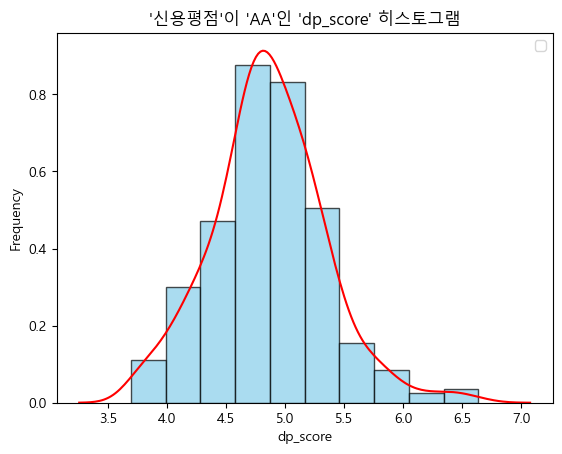

In [22]:
# '신용평점'이 'A'인 행들의 'dp_score' 열 데이터를 가져옵니다.
filtered_data = df_total_filtered_2[df_total_filtered_2['신용평점'] == 'AA']['dp_score']

# 히스토그램 그리기
plt.hist(filtered_data, bins=10, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# 확률밀도선 그리기
sns.kdeplot(filtered_data, color='red')

# 라벨 및 범례 추가
plt.title("'신용평점'이 'AA'인 'dp_score' 히스토그램")
plt.xlabel('dp_score')
plt.ylabel("Frequency")
plt.legend()

# 그래프 출력
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


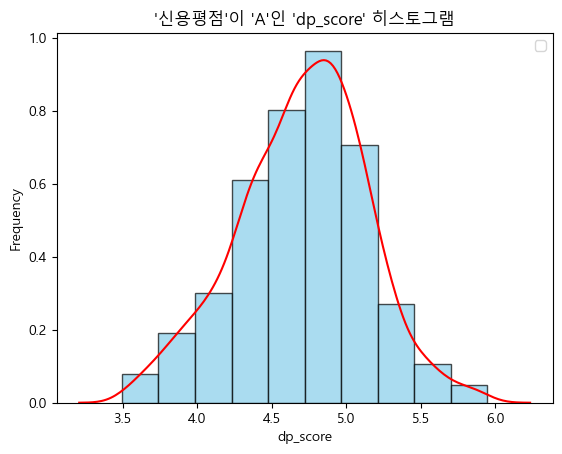

In [23]:
# '신용평점'이 'A'인 행들의 'dp_score' 열 데이터를 가져옵니다.
filtered_data = df_total_filtered_2[df_total_filtered_2['신용평점'] == 'A']['dp_score']

# 히스토그램 그리기
plt.hist(filtered_data, bins=10, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# 확률밀도선 그리기
sns.kdeplot(filtered_data, color='red')

# 라벨 및 범례 추가
plt.title("'신용평점'이 'A'인 'dp_score' 히스토그램")
plt.xlabel('dp_score')
plt.ylabel("Frequency")
plt.legend()

# 그래프 출력
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


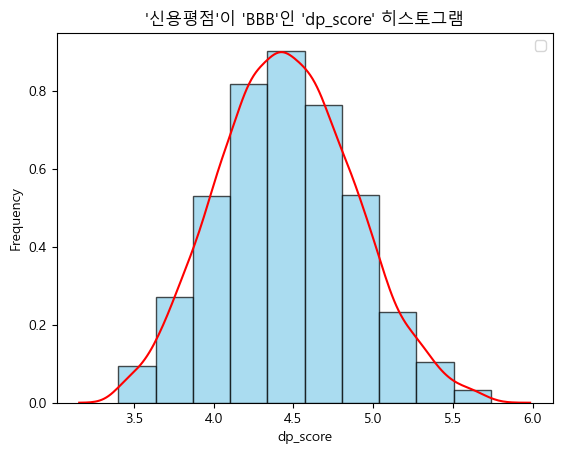

In [24]:
# '신용평점'이 'A'인 행들의 'dp_score' 열 데이터를 가져옵니다.
filtered_data = df_total_filtered_2[df_total_filtered_2['신용평점'] == 'BBB']['dp_score']

# 히스토그램 그리기
plt.hist(filtered_data, bins=10, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# 확률밀도선 그리기
sns.kdeplot(filtered_data, color='red')

# 라벨 및 범례 추가
plt.title("'신용평점'이 'BBB'인 'dp_score' 히스토그램")
plt.xlabel('dp_score')
plt.ylabel("Frequency")
plt.legend()

# 그래프 출력
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


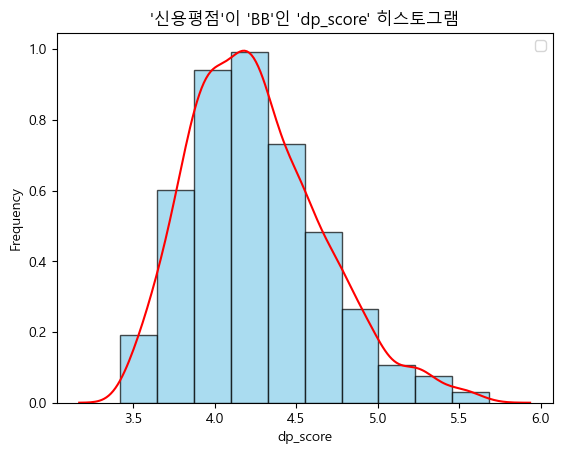

In [25]:
# '신용평점'이 'A'인 행들의 'dp_score' 열 데이터를 가져옵니다.
filtered_data = df_total_filtered_2[df_total_filtered_2['신용평점'] == 'BB']['dp_score']

# 히스토그램 그리기
plt.hist(filtered_data, bins=10, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# 확률밀도선 그리기
sns.kdeplot(filtered_data, color='red')

# 라벨 및 범례 추가
plt.title("'신용평점'이 'BB'인 'dp_score' 히스토그램")
plt.xlabel('dp_score')
plt.ylabel("Frequency")
plt.legend()

# 그래프 출력
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


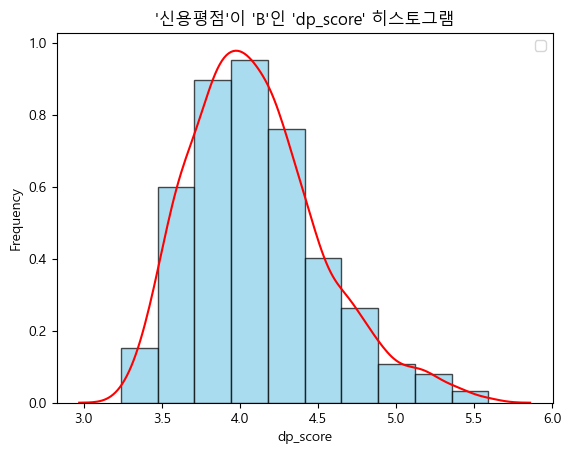

In [26]:
# '신용평점'이 'A'인 행들의 'dp_score' 열 데이터를 가져옵니다.
filtered_data = df_total_filtered_2[df_total_filtered_2['신용평점'] == 'B']['dp_score']

# 히스토그램 그리기
plt.hist(filtered_data, bins=10, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# 확률밀도선 그리기
sns.kdeplot(filtered_data, color='red')

# 라벨 및 범례 추가
plt.title("'신용평점'이 'B'인 'dp_score' 히스토그램")
plt.xlabel('dp_score')
plt.ylabel("Frequency")
plt.legend()

# 그래프 출력
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


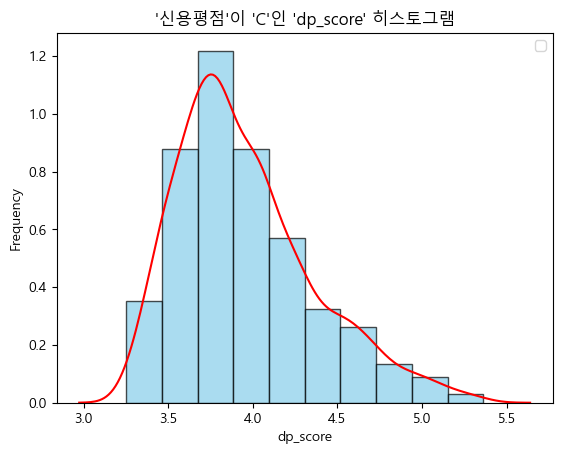

In [27]:
# '신용평점'이 'A'인 행들의 'dp_score' 열 데이터를 가져옵니다.
filtered_data = df_total_filtered_2[df_total_filtered_2['신용평점'] == 'C']['dp_score']

# 히스토그램 그리기
plt.hist(filtered_data, bins=10, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# 확률밀도선 그리기
sns.kdeplot(filtered_data, color='red')

# 라벨 및 범례 추가
plt.title("'신용평점'이 'C'인 'dp_score' 히스토그램")
plt.xlabel('dp_score')
plt.ylabel("Frequency")
plt.legend()

# 그래프 출력
plt.show()

---

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


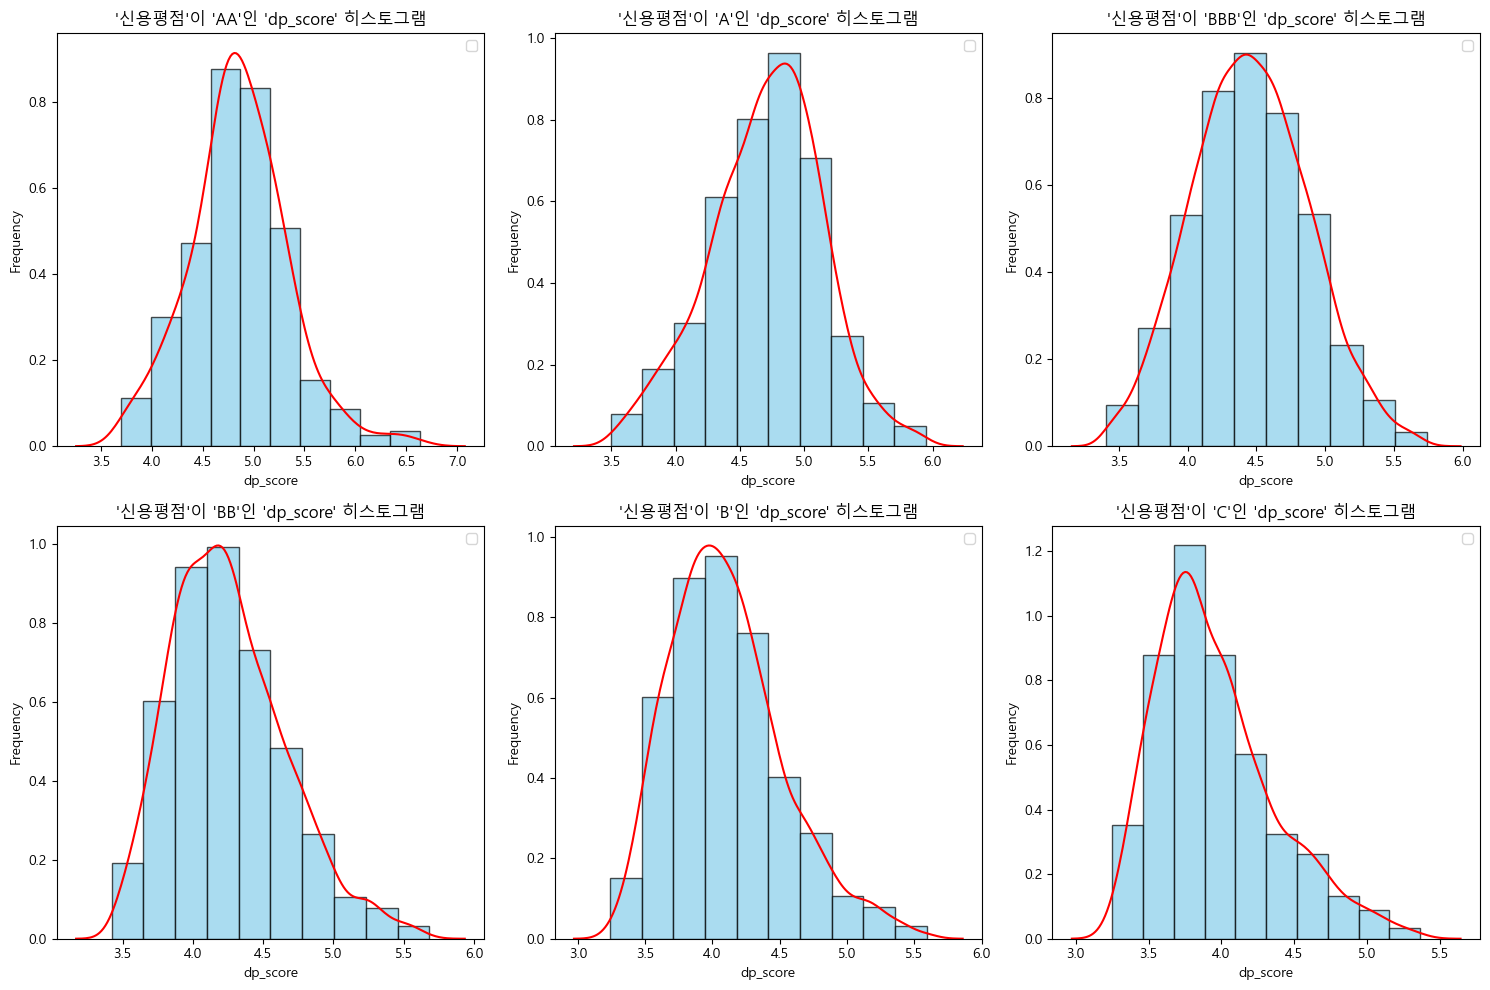

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_subplots(dataframe):
    # 신용평점 종류 리스트
    credit_ratings = ['AA', 'A', 'BBB', 'BB', 'B', 'C']

    # 2x3 서브플롯 생성
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, credit_rating in enumerate(credit_ratings):
        # '신용평점'이 해당 등급인 행들의 'dp_score' 열 데이터를 가져옵니다.
        filtered_data = dataframe[dataframe['신용평점'] == credit_rating]['dp_score']

        # 히스토그램 그리기
        axes[i].hist(filtered_data, bins=10, density=True, alpha=0.7, color='skyblue', edgecolor='black')

        # 확률밀도선 그리기
        sns.kdeplot(filtered_data, color='red', ax=axes[i])

        # 타이틀 및 라벨 추가
        axes[i].set_title(f"'신용평점'이 '{credit_rating}'인 'dp_score' 히스토그램")
        axes[i].set_xlabel('dp_score')
        axes[i].set_ylabel("Frequency")
        axes[i].legend()

    # 서브플롯 간 간격 조정
    plt.tight_layout()

    # 그래프 출력
    plt.show()

# 데이터프레임에는 'df_total_filtered_2'를 사용하도록 가정합니다.
draw_subplots(df_total_filtered_2)


In [29]:
df_total_filtered_2['dp_score'].mean()

4.334170439813625

---

In [30]:
# df_total_filtered_2[['회사명','신용평점','dp_score']].to_csv('회신dpscore.csv')

In [31]:
df_total_filtered_2.iloc[12920:1970,:]

,회사명,거래소코드,유동자산회전률,총자산대비잉여현금흐름,자기자본구성비율,log자산총계,자기자본회전률,순운전자본회전률,자기자본증가율,총자본증가율,총자산대비현금흐름,총자본투자효율,KIS,신용평점,dp_score
